# Embedding Adaptors

## Installation

In [44]:
%pip install -q -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


## Helper function to display the results of the vector search

In [45]:
def print_results_and_documents(results, retrieved_documents, word_wrap):
    """
    Prints keys and values from the results dictionary and documents with word wrapping.

    Args:
        results (dict): A dictionary where keys are strings and values are either strings or lists.
        retrieved_documents (list): A list of documents to be printed.
        word_wrap (function): A function to apply word wrapping to the documents.

    Returns:
        None
    """
    # Iterate through the dictionary and print each key with its associated value
    for key, value in results.items():
        print(f"{key}:")

        # Check if the value is a list and print its elements
        if isinstance(value, list):
            for i, item in enumerate(value):
                print(f"  Item {i+1}: {item}")
        else:
            # Directly print the value if it's not a list
            print(f"  {value}")

        print()  # Add a newline for better readability

    # Iterate through the list of documents and print each one with word wrapping
    for document in retrieved_documents:
        print(word_wrap(document))
        print('\n')

## Connecting to the vector database

In [46]:
import chromadb
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings
import numpy as np
import umap
from tqdm import tqdm
import torch

chroma_client = chromadb.PersistentClient(
    path="data/chroma_db/",
    settings=Settings(),
    tenant=DEFAULT_TENANT,
    database=DEFAULT_DATABASE,
)
# Load the existing collection by its name
collection_name = 'microsoft_annual_report_2022'
chroma_collection = chroma_client.get_or_create_collection(name=collection_name)

# Count the number of items in the collection
count = chroma_collection.count()
print(f"Number of items in the collection '{collection_name}': {count}")

Number of items in the collection 'microsoft_annual_report_2022': 349


## Setting up the embedding function

In [47]:
# Access the underlying SentenceTransformer model (Defults)
embedding_function = SentenceTransformerEmbeddingFunction()
model = embedding_function.models
print(model)

{'all-MiniLM-L6-v2': SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)}


## Retrieve the embeddings

In [48]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/vscode/my-envs/03-rag-graph-databases/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [02:49<00:00,  2.06it/s]


## Creating a synthetic dataset with OpenAI

In [49]:
from openai import OpenAI
openai_client=OpenAI()

def generate_queries(model="gpt-4o-mini"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

We use GPT to generate a dataset of expert questions from GPT-3.5.

In [50]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

1. What were the company's total revenues for the year?
2. What were the company's total expenses for the year?
3. What was the company's net income for the year?
4. How much did the company spend on research and development?
5. What were the company's total assets at the end of the year?
6. What were the company's total liabilities at the end of the year?
7. How much cash does the company have on hand?
8. What is the company's debt-to-equity ratio?
9. How much did the company pay out in dividends?
10. What were the earnings per share for the year?
11. How much did the company spend on capital expenditures?
12. What were the company's operating cash flows for the year?
13. What were the company's investing cash flows for the year?
14. What were the company's financing cash flows for the year?
15. How did the company's financial performance compare to previous years?


We asked the LLM (GPT) to generate 15 questions. Now we ask thes 15 questions against our chromDB vector store to get the relavant chunks.

In [51]:
results = chroma_collection.query(query_texts=generated_queries,
                                   n_results=10, 
                                   include=['documents', 'embeddings', "distances"])

retrieved_documents = results['documents'][0]
print_results_and_documents(results, retrieved_documents, word_wrap)

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

ids:
  Item 1: ['331', '321', '134', '323', '319', '241', '145', '322', '125', '151']
  Item 2: ['152', '150', '226', '331', '322', '206', '241', '323', '199', '175']
  Item 3: ['283', '152', '241', '194', '195', '140', '196', '200', '202', '143']
  Item 4: ['150', '225', '183', '323', '142', '319', '272', '321', '111', '275']
  Item 5: ['199', '272', '197', '202', '205', '36', '322', '269', '125', '200']
  Item 6: ['199', '220', '260', '169', '197', '206', '259', '221', '200', '198']
  Item 7: ['199', '169', '258', '323', '297', '241', '195', '295', '275', '269']
  Item 8: ['199', '205', '167', '179', '201', '324', '197', '221', '272', '273']
  Item 9: ['34', '311', '205', '306', '195', '241', '172', '36', '199', '161']
  Item 10: ['241', '195', '36', '205', '242', '199', '311', '193', '34', '140']
  Item 11: ['152', '150', '166', '269', '272', '142', '206', '226', '319', '271']
  Item 12: ['200', '169', '166', '295', '125', '324', '206', '331', '132', '198']
  Item 13: ['162', '166',

In [52]:
retrieved_documents = results['documents']

Then we query those questions against our embeddings (ChromaDB).

## Judging the results

In [53]:
def evaluate_results(query, statement, model="gpt-4o-mini"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

The evaluate_results function above should return 1 or -1 as the expert (LLM Judge) from the prompt of the "query" and "statement".  The statement will be the chunck.

## Setup the embeddings

In [54]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

Save the retrieved embeddings (all the chunks) and the original queries embeddings. 

In [55]:
#Embedddings of our queries
adapter_query_embeddings = []
#Embeddings of our documents
adapter_doc_embeddings = []
# Labels will come from the evalation model (1 or -1)
adapter_labels = []

q and d are the counters

In [56]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [03:03<00:00, 12.23s/it]


Labels are going to be the output of our loss function (evalaute_results)
With cosine similatity 1 = identical and -1 = oppisite.    

In [57]:
len(adapter_labels)

150

## Converting to Pytorch sensor

15 questions with 10 results each (150). Now we perform a conversion of the adapter_query_embeddings variable into a PyTorch tensor. Has to be a NumPy array. Labels are the (yes=1) or (no=-1)

In [58]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

We need to turn our dataset into a torch tensor dataset

In [59]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

Note: Then pack everything into a Torch dataset

## Setting up the model

In [60]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

In [61]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

The following code creates a random matrix. This matrix is randomly initialized and is set up so that it can be learned during the training process. This generates a matrix of size 384 with elements drawn from a standard normal distribution (mean = 0, variance = 1).

requires_grad=True:
This flag tells PyTorch that it should keep track of gradients for this tensor during backpropagation. This means the adapter_matrix will be updated during the training process, allowing it to learn a transformation that is optimized for the task at hand.

In [62]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
print("vector dimension ",mat_size)
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

vector dimension  384


In [63]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

  0%|          | 0/100 [00:00<?, ?it/s]/home/vscode/my-envs/03-rag-graph-databases/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


In [64]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.45257508754730225


Note: We got a best loss 0f .05. Which means we got a half way improvement in terms of where we started from. 

In [65]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

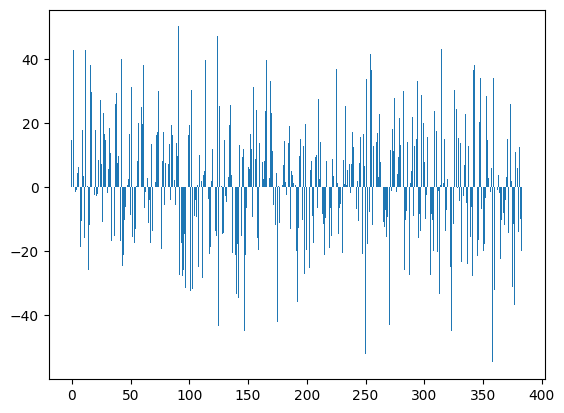

In [66]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [67]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


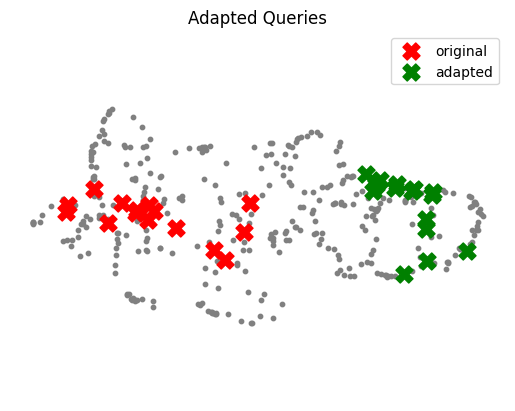

In [68]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()